# Applying the Hidden Markov Model on Budget allocation

The hidden markov model would recommend a budget using conversion state transitions, budget emissions, and return on investment indicators 

### Objective
Minimize the budget _B<sub>t</sub>_ to transition from state _S<sub>t</sub>_ to _S<sub>t+1</sub>_

### Subject to
* Sum of _B<sub>t</sub>_ <= _B_;  for all _t_
* RMS of _R_ <= $\epsilon$; where _R_ is the Residual of the expected and actual return on investmenet _B_
* Sum of _S<sub>t+1</sub> - S<sub>t</sub>_ <= _T_; where _T_ is the total allowable time period to complete all transitions from S<sub>start</sub> to S<sub>final</sub>

#### Reference
[Analyzing Time Series Data with Markov Transition Matrices](https://medium.com/towards-data-science/time-series-data-markov-transition-matrices-7060771e362b)

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


## Instantiate Classes

In [3]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.etl.loader import sparkFile as file
# from rezaware.modules.etl.loader import __propAttr__ as attr

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"
# clsSDB = db.dataWorkLoads(
#     desc=__desc__,
#     db_type = 'bigquery',
#     db_driver=None,
#     db_hostIP=None,
#     db_port = None,
#     db_name = None,
#     db_schema='combined_data_facebook_ads',
#     spark_partitions=None,
#     spark_format = 'bigquery',
#     spark_save_mode=None,
#     # spark_jar_dir = _jar,
# )
clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write BigQuery dataset for hypothese testing class initialization and load complete!


## Load data

In [4]:
options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path="mining/data/budget/",  # optional - relative path, w.r.t. self.storeRoot
        file_name="complete-60-accounts.csv",  # optional - name of the file to read
        file_type=None,  # optional - read all the files of same type
        **options,
)
print("Loaded %d rows" % sdf.count())
sdf.printSchema()

25/02/15 16:25:22 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/15 16:25:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/15 16:25:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
                                                                                

Loaded 61513 rows
root
 |-- account_id: long (nullable = true)
 |-- ad_id: long (nullable = true)
 |-- adset_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- reach: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- ROAS: double (nullable = true)
 |-- social_spend: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- click: integer (nullable = true)
 |-- auction_bid: integer (nullable = true)
 |-- goal: string (nullable = true)
 |-- purchase_value: double (nullable = true)
 |-- account_currency: string (nullable = true)
 |-- purchase: double (nullable = true)
 |-- fb_pixel_view_value: double (nullable = true)
 |-- fb_pixel_purchase_value: double (nullable = true)
 |-- fb_pixel_add_to_cart_value: double (nullable = true)
 |-- mobile_app_purc

## Filter data into Inputs and Outputs


In [28]:
from pyspark.sql import functions as F

filt_sdf = sdf.select('spend','CTR', 'CPC', 'CPM', 'ROAS').dropna()
print(filt_sdf.count())
mean_stddev_sdf = filt_sdf.agg(F.mean('spend').alias('spend_mean'), F.mean('CTR').alias('CTR_mean'), 
                        F.mean('CPC').alias('CPC_mean'), F.mean('CPM').alias('CPM_mean'), 
                        F.mean('ROAS').alias('ROAS_mean'),
                        F.stddev('spend').alias('spend_stddev'), F.stddev('CTR').alias('CTR_stddev'), 
                        F.stddev('CPC').alias('CPC_stddev'), F.stddev('CPM').alias('CPM_stddev'),
                        F.mean('ROAS').alias('ROAS_stddev'))
_lb = mean_stddev_sdf.select(F.col('spend_mean')).first()[0] + \
        3*mean_stddev_sdf.select(F.col('spend_stddev')).first()[0]
filt_sdf = filt_sdf.select('*').where(F.col('spend') <= _lb)
                   
print(filt_sdf.count())

26193
25554


In [61]:
    # 'spend','omni_view_content_value', 'omni_add_to_cart_value',
    # 'omni_initiated_checkout_value', 'omni_purchase_value').dropna().collect())

_data_df= sdf.select('spend','CTR', 'CPC', 'CPM', 'ROAS').dropna().toPandas()
print(_data_df.shape)
_data_df = _data_df[_data_df['spend']<=\
                    _data_df['spend'].mean()+2*_data_df['spend'].std()]
_data_df = _data_df[_data_df['CTR']<=\
                    _data_df['CTR'].mean()+2*_data_df['CTR'].std()]
_data_df = _data_df[_data_df['CPC']<=\
                    _data_df['CPC'].mean()+2*_data_df['CPC'].std()]
_data_df = _data_df[_data_df['ROAS']<=\
                    _data_df['ROAS'].mean()+2*_data_df['ROAS'].std()]
_data_df = _data_df[_data_df['CPM']<=\
                    _data_df['CPM'].mean()+2*_data_df['CPM'].std()]
# _data_df = _data_df[_data_df['spend']<=4000]

_data_df = _data_df.sample(n=1000)

print("data shape:", _data_df.shape)
print("data quartile  :", _data_df.describe())

(26193, 5)
data shape: (1000, 5)
            spend          CTR          CPC          CPM         ROAS
count  1000.00000  1000.000000  1000.000000  1000.000000  1000.000000
mean   1353.51126     3.495548     3.704650    88.710291     3.672618
std    1378.39755     2.648121     3.289767    73.112959     8.818108
min       3.00000     0.296883     0.100000     5.486355     0.069855
25%     235.91000     1.423133     1.234649    25.518812     0.855013
50%     717.99500     2.613780     3.148969    56.681347     1.480782
75%    2512.50250     4.571602     5.159725   146.481902     2.799525
max    4371.23000    11.139263    19.841667   267.869227   169.184290


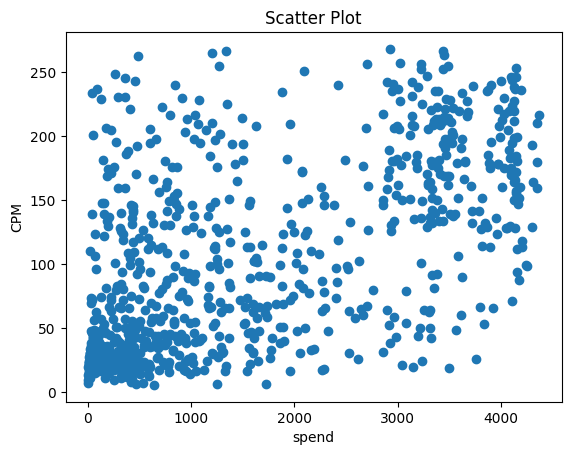

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(_data_df['spend'],_data_df['CPM'])
plt.title("Scatter Plot")
plt.xlabel("spend")
plt.ylabel("CPM")
plt.show()

## Define the model

* [Probabilistic Modeling with TensorFlow Probability](https://www.scaler.com/topics/tensorflow/tensorflow-probability/)
* [Tensorflow probability examples](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/examples/jupyter_notebooks)

## Split the train & test data

In [32]:
# Compile and train the standard neural network
_pred_cols = ['CTR','CPC', 'CPM', 'ROAS']
_label_col = ['spend']
X = np.array(_data_df[_pred_cols])
y = np.array(_data_df[_label_col])             
print("X: ",X.shape,"y: ", y.shape)

X:  (1000, 4) y:  (1000, 1)


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print("X_train: ",X_train.shape, "y_train: ", y_train.shape,
      "\nX_test: ", X_test.shape, "y_test: ", y_test.shape)

X_train:  (800, 4) y_train:  (800, 1) 
X_test:  (200, 4) y_test:  (200, 1)


In [35]:
X_reshaped = np.tile(X[:, np.newaxis, :], (1, 100, 1)) 
print(X_reshaped.shape)

(1000, 100, 4)


## DistibutionLambda wrapper function

In [9]:
from tensorflow.keras.layers import Layer
class DistributionLambdaLayer(Layer):
    def __init__(self, **kwargs):
        super(DistributionLambdaLayer, self).__init__(**kwargs)
        self.dist_lambda = tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(loc=t, scale=1)
        )

    def call(self, inputs):
        # Get the distribution
        distribution = self.dist_lambda(inputs)
        # Return a tensor (e.g., the mean of the distribution)
        return distribution.mean()

## Custom loss function

In [46]:
# Define a custom loss function
# custom_loss = lambda y, y_pred: -y_pred.log_prob(y)

# def custom_loss(y_true, y_pred):
#     return -y_pred.log_prob(y_true)

def custom_loss(y_true, y_pred):
    # Reshape y_true to match y_pred's shape
    y_true = tf.expand_dims(y_true, axis=-1)  # Shape: [8] -> [8, 1]
    y_true = tf.expand_dims(y_true, axis=-1)  # Shape: [8, 1] -> [8, 1, 1]
    y_true = tf.tile(y_true, [1, 100, 32])   # Shape: [8, 1, 1] -> [8, 100, 32]

    # Recreate the distribution
    dist = tfp.distributions.Normal(loc=y_pred, scale=1)
    # Compute the negative log probability
    return -dist.log_prob(y_true)

In [56]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, LSTM, Lambda

# Step 1: Generate or load your data
# Example: Create dummy data
num_samples = 1000  # Number of samples
num_timesteps = 100  # Number of time steps
num_features = 4  # Number of features per time step
num_classes = 10  # Number of output classes

# X has shape (num_samples, num_features)
X = np.random.rand(num_samples, num_features)  # Example input data
# Reshape X to (num_samples, num_timesteps, num_features)
X_reshaped = np.tile(X[:, np.newaxis, :], (1, num_timesteps, 1))

# y has shape (num_samples,)
y = np.random.randint(0, num_classes, size=num_samples)  # Example target data
# Reshape y to (num_samples, num_timesteps, 1)
y_reshaped = np.tile(y[:, np.newaxis, np.newaxis], (1, num_timesteps, 1))

# Split data into training and testing sets
split = int(0.8 * num_samples)  # 80% training, 20% testing
x_train, x_test = X_reshaped[:split], X_reshaped[split:]
y_train, y_test = y_reshaped[:split], y_reshaped[split:]

# Step 2: Define the model
# Input layer expects (num_timesteps, num_features)
inputs = Input(shape=(num_timesteps, num_features))

# LSTM layer for sequential data
x = LSTM(64, return_sequences=True)(inputs)

# Dense layer
x = Dense(32, activation='relu')(x)

# Output a distribution (e.g., Normal distribution) and extract the mean
outputs = Lambda(
    lambda t: tfp.distributions.Normal(loc=t, scale=1).mean(),  # Extract the mean
    output_shape=(num_timesteps, 32)  # Specify the output shape
)(x)

# Create the model
model = Model(inputs, outputs)

# Step 3: Define a custom loss function
def custom_loss(y_true, y_pred):
    # Ensure y_true has the correct shape [batch_size, num_timesteps, 1]
    y_true = tf.reshape(y_true, [-1, num_timesteps, 1])  # Reshape to [batch_size, num_timesteps, 1]

    # Recreate the distribution
    dist = tfp.distributions.Normal(loc=y_pred, scale=1)
    # Compute the negative log probability
    return -dist.log_prob(y_true)

# Step 4: Compile the model
model.compile(optimizer='adam', loss=custom_loss)

# Step 5: Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1)

# Step 6: Evaluate the model on the test set
# Generate predictions for the test set
y_pred = model.predict(x_test)

# Print the shapes of y_test and y_pred
print("y_test shape:", y_test.shape)  # Should be (num_test_samples, num_timesteps, 1)
print("y_pred shape:", y_pred.shape)  # Should be (num_test_samples, num_timesteps, 32)

# Step 7: Evaluate the predictions
# Compute the mean squared error (MSE) between y_test and y_pred
mse = tf.keras.losses.MeanSquaredError()
mse_value = mse(y_test, y_pred).numpy()
print("Mean Squared Error (MSE) on test set:", mse_value)

# Step 8: Summary of the model
model.summary()

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 14.9526
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.8375 
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7.4172
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.8330
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.6153
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.3438
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.6200
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.5274 
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.6954
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 6.5355 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step 
y_test shape: (200, 100, 1)
y_pred shape: (200, 100, 32)
Mean Squared Error (MSE) on test set: 11.070491


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 100, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100, 64)        │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 100, 32)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,234 (231.39 KB)

 Trainable params: 19,744 (77.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,490 (154.26 KB)